In [3]:
import torch
from torch_geometric.data import Data
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sys
sys.path.append('/Volumes/Lab/Users/bhofflic/cell_classification/src/')
import file_handling
import pickle

path = '/Volumes/Scratch/Users/bhofflic/cell_correlations/gnn_data/'

## Load Data

In [4]:
gnn_data = pickle.load(open(path + 'gnn_data.pkl', 'rb'))

In [5]:
from torch_geometric.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, graph_list):
        super(CustomDataset, self).__init__()
        self.graph_list = graph_list

    def len(self):
        return len(self.graph_list)

    def get(self, idx):
        return self.graph_list[idx]

## Define Node and Edge Features and Connectivity

In [6]:
import pandas as pd
import numpy as np

def create_edges(df, threshold):
    # Convert DataFrame to numpy for faster processing
    corr_matrix = df.to_numpy()
    node_ids = df.index

    # Get indices for upper and lower triangles excluding the diagonal
    i_upper, j_upper = np.triu_indices(corr_matrix.shape[0], k=1)
    i_lower, j_lower = np.tril_indices(corr_matrix.shape[0], k=-1)

    # Concatenate indices for both triangles
    i = np.concatenate((i_upper, i_lower))
    j = np.concatenate((j_upper, j_lower))

    # Apply threshold and get indices for high correlations
    high_corr = np.abs(corr_matrix[i, j]) >= threshold

    # Get pairs of nodes with high correlation
    node_pairs = np.vstack((node_ids[i], node_ids[j])).T

    # Determine edge types based on the sign of correlation
    edge_types = np.where(corr_matrix[i, j][high_corr] > 0, 1, 0)

    # Combine node pairs with their edge types
    edges = np.column_stack((node_pairs[high_corr], edge_types))
    edges = edges.astype(int)

    edge_index = edges[:,:2]
    edge_features = edges[:,2]

    return edge_index, edge_features

All nodes in One Large Graph

In [7]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

label_encoder = LabelEncoder()

node_features = gnn_data[['tc','tc_all','acf']].applymap(lambda x: x.a)
node_features = np.stack(node_features.apply(np.concatenate, axis=1).to_numpy())
node_features = node_features / np.linalg.norm(node_features, axis=0)

node_feature_dict = {str(i): node_features[i] for i in range(len(node_features))}
node_corrs = pd.DataFrame(node_feature_dict).corr()

edges, edge_features = create_edges(node_corrs, 0.5)

labels = label_encoder.fit_transform(gnn_data['label'])

node_features_tensor = torch.tensor(node_features, dtype=torch.float)
labels_tensor = torch.tensor(labels, dtype=torch.long)
edge_index_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_features_tensor = torch.tensor(edge_features, dtype=torch.long)

data = Data(x=node_features_tensor,
            edge_index=edge_index_tensor,
            y=labels_tensor,
            edge_attr=edge_features_tensor)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:int(data.num_nodes*0.7)] = 1
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[int(data.num_nodes*0.7):int(data.num_nodes*0.8)] = 1
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[int(data.num_nodes*0.8):] = 1
print(data)
aio_data = data

Data(x=[11238, 18], edge_index=[2, 13531294], edge_attr=[13531294], y=[11238], train_mask=[11238], val_mask=[11238], test_mask=[11238])


In [8]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

all_graphs = []
for piece_num, piece_id in enumerate(gnn_data['piece_id'].unique()):
    piece_data = gnn_data[gnn_data['piece_id'] == piece_id]
    node_features = piece_data[['tc','tc_all','acf']].applymap(lambda x: x.a)
    node_features = np.stack(node_features.apply(np.concatenate, axis=1).to_numpy())
    node_features = node_features / np.linalg.norm(node_features, axis=0)

    node_feature_dict = {str(i): node_features[i] for i in range(len(node_features))}
    node_corrs = pd.DataFrame(node_feature_dict).corr()

    edges, edge_features = create_edges(node_corrs, 0.5)

    labels = label_encoder.transform(piece_data['label'])

    node_features_tensor = torch.tensor(node_features, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    edge_index_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_features_tensor = torch.tensor(edge_features, dtype=torch.long)

    data = Data(x=node_features_tensor,
                edge_index=edge_index_tensor,
                y=labels_tensor,
                edge_attr=edge_features_tensor)
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[:int(data.num_nodes*0.8)] = 1
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask[int(data.num_nodes*0.8):] = 1
    all_graphs.append(data)
    print(data)

Data(x=[803, 18], edge_index=[2, 138894], edge_attr=[138894], y=[803], train_mask=[803], test_mask=[803])


Data(x=[586, 18], edge_index=[2, 85852], edge_attr=[85852], y=[586], train_mask=[586], test_mask=[586])
Data(x=[429, 18], edge_index=[2, 78218], edge_attr=[78218], y=[429], train_mask=[429], test_mask=[429])
Data(x=[804, 18], edge_index=[2, 143432], edge_attr=[143432], y=[804], train_mask=[804], test_mask=[804])
Data(x=[592, 18], edge_index=[2, 105644], edge_attr=[105644], y=[592], train_mask=[592], test_mask=[592])
Data(x=[489, 18], edge_index=[2, 59702], edge_attr=[59702], y=[489], train_mask=[489], test_mask=[489])
Data(x=[610, 18], edge_index=[2, 101248], edge_attr=[101248], y=[610], train_mask=[610], test_mask=[610])
Data(x=[832, 18], edge_index=[2, 150838], edge_attr=[150838], y=[832], train_mask=[832], test_mask=[832])
Data(x=[742, 18], edge_index=[2, 119240], edge_attr=[119240], y=[742], train_mask=[742], test_mask=[742])
Data(x=[726, 18], edge_index=[2, 112702], edge_attr=[112702], y=[726], train_mask=[726], test_mask=[726])
Data(x=[585, 18], edge_index=[2, 59294], edge_attr=[

In [9]:
label_classes = label_encoder.classes_

# Plot Network Subset

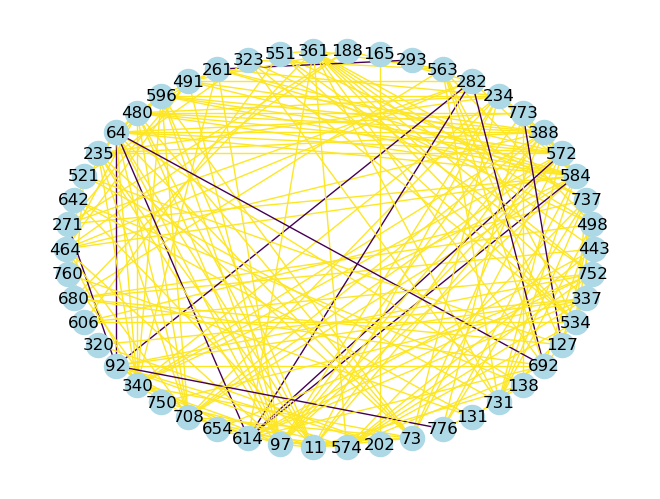

In [10]:
import networkx as nx
data = all_graphs[0]

import torch_geometric as pyg
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming you have a PyG dataset named `data`
edge_index = data.edge_index
edge_attr = data.edge_attr  # edge_attr are integers representing edge types

# Number of nodes to visualize
num_nodes_to_visualize = 50

# Select a random subset of nodes
all_nodes = list(range(data.num_nodes))
subset_nodes = random.sample(all_nodes, num_nodes_to_visualize)

# Create a NetworkX graph from the subset
G = nx.Graph()

# Add nodes
G.add_nodes_from(subset_nodes)

# Add edges
for i, edge in enumerate(edge_index.t()):
    src, dest = edge.tolist()
    if src in subset_nodes and dest in subset_nodes:
        # Add edge with type as attribute
        G.add_edge(src, dest, type=edge_attr[i].item())  # convert to Python scalar if necessary

# Determine the number of unique edge types
num_edge_types = len(torch.unique(edge_attr))

# Map edge types to colors
color_map = plt.cm.get_cmap('viridis', num_edge_types)
edge_colors = [color_map(G[u][v]['type']) for u, v in G.edges()]

pos = nx.circular_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_color='lightblue')
plt.show()


# Visualize Node Separation

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


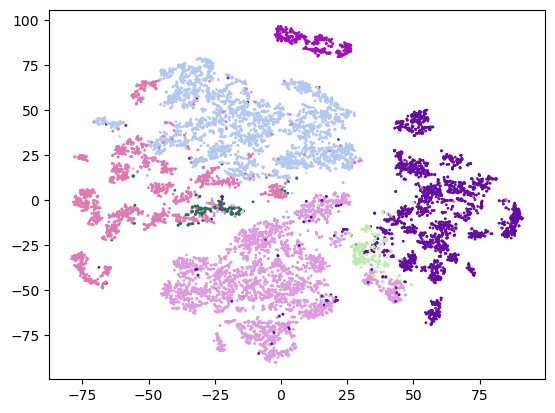

In [11]:
all_nodes = aio_data.x.numpy()
all_labels = aio_data.y.numpy()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

edge_tsne = tsne.fit_transform(np.array(all_nodes))
def generate_unique_color():
    return np.random.rand(3,)

labels = all_labels
label_colors = {label: generate_unique_color() for label in np.unique(labels)}
colors = np.array([label_colors[i] for i in labels])

for i,label in enumerate(np.unique(labels)):
    mask = labels == label
    filtered_edge_tsne = edge_tsne[mask]
    plt.scatter(filtered_edge_tsne[:,0],filtered_edge_tsne[:,1],s=1,c=colors[mask], label=label)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1),markerscale=10)

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


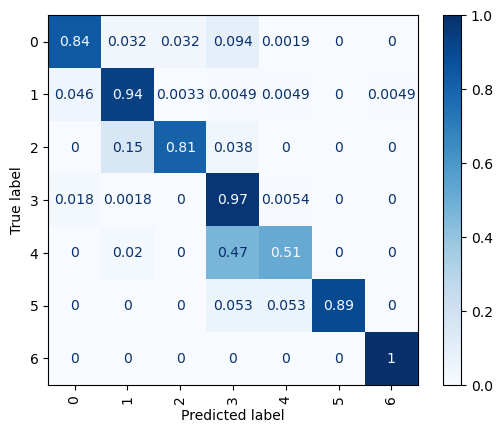

In [12]:
#SVM classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

all_nodes = aio_data.x.numpy()
all_labels = aio_data.y.numpy()

# Assuming 'labels' is your array of class labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = aio_data.x[aio_data.train_mask].numpy(), aio_data.x[aio_data.test_mask].numpy(), aio_data.y[aio_data.train_mask].numpy(), aio_data.y[aio_data.test_mask].numpy()

#Train the SVM
clf = SVC(kernel='poly', class_weight=weight_dict, probability=True)
clf.fit(X_train, y_train)

#Test the SVM
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true', xticks_rotation='vertical')

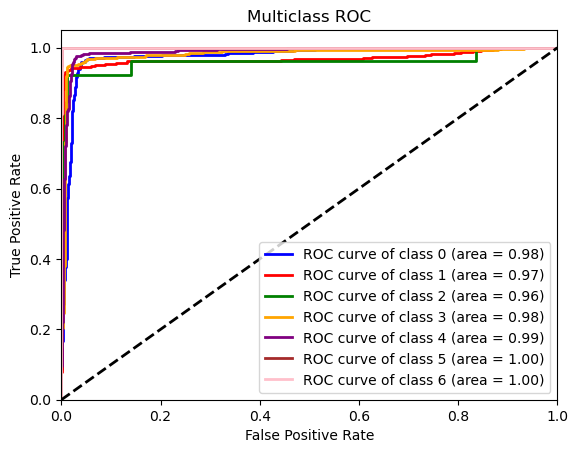

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming svm_model is your trained SVM model and X_test is your test data
y_score = clf.predict_proba(X_test)  # Ensure your model outputs probabilities for each class

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output labels for multiclass
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()


RGCN Model

In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}, {torch.cuda.current_device()}')

Device: cuda, 0


In [18]:
data = aio_data.to(device)
num_features = 18  # Number of node features
num_classes = 7   # Number of classes for classification
num_relations = 2   # For positive and negative correlations

model = RGCN(num_features, 64, num_classes, num_relations).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

class_counts = [len(np.where(data.y.cpu().numpy() == i)[0]) for i in range(num_classes)]
total_count = sum(class_counts)
class_weights = [total_count / c for c in class_counts]
weights_tensor = torch.tensor(class_weights, dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor).to(device)

from sklearn.metrics import confusion_matrix

def evaluate(mask, return_cm = False):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index, data.edge_attr)
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    if return_cm:
        cm = confusion_matrix(data.y[mask].cpu(), pred.cpu())
    if return_cm:
        return acc, cm
    return acc

train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10000
# Run the training process
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    train_losses.append(loss.cpu().detach().numpy())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Evaluate on the test set
test_accs = evaluate(data.test_mask, return_cm=True)
print(f'Test Accuracy: {test_accs[0]}')
print(test_accs[1])

  0%|          | 0/10000 [00:00<?, ?it/s]

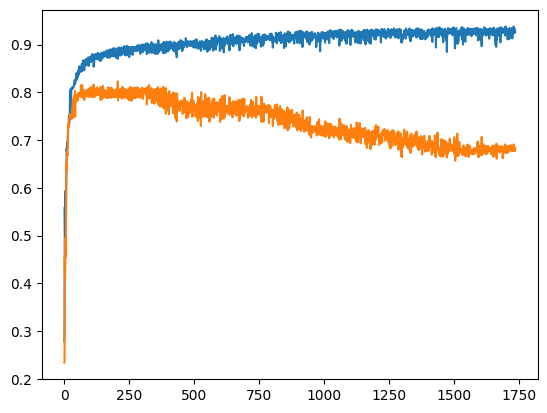

In [ ]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)